<a href="https://colab.research.google.com/github/SarahGoddaer/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Second_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Second try


In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import numpy as np
from sklearn import metrics

Loading data

In [52]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")
testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

print(trainset.head())
print(trainset.shape)
print(testset.head())
print(testset.shape)
print(trainset.label.value_counts())

       AF3       F7       F3      FC5  ...       F4       F8      AF4  label
0  4299.49  3997.44  4277.95  4116.92  ...  4278.97  4600.00  4369.23      1
1  4302.05  3985.64  4261.03  4129.74  ...  4283.08  4607.18  4358.46      0
2  4321.03  4015.90  4265.13  4122.56  ...  4286.15  4608.21  4371.79      0
3  4408.21  4104.10  4380.00  4232.31  ...  4388.21  4715.90  4464.10      0
4  4347.18  3975.38  4266.67  4102.56  ...  4313.33  4664.10  4411.79      1

[5 rows x 15 columns]
(2000, 15)
       AF3       F7       F3      FC5  ...       F4       F8      AF4  index
0  4296.41  4040.51  4253.33  4124.10  ...  4268.72  4598.46  4342.56      0
1  4291.28  3994.36  4247.18  4102.56  ...  4260.51  4593.33  4337.95      1
2  4299.49  4019.49  4269.74  4116.41  ...  4280.51  4596.92  4350.26      2
3  4280.00  4004.62  4263.59  4120.51  ...  4271.79  4608.72  4344.10      3
4  4317.44  3968.72  4260.51  4101.54  ...  4282.05  4592.31  4372.82      4

[5 rows x 15 columns]
(12892, 15)
0    10

**Pre-processing: scaling data**: If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

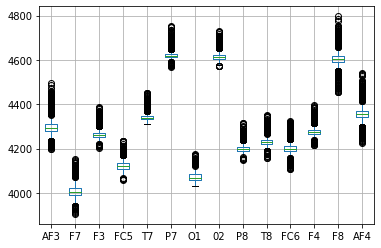

In [53]:
#defining features of train and testset
features = trainset.copy()
features.pop('label')
feature_names = list(features.columns)

test_features = testset.copy()
test_features.pop('index')
test_feature_names = list(test_features.columns)
#visualizing features' ranges
features.boxplot()

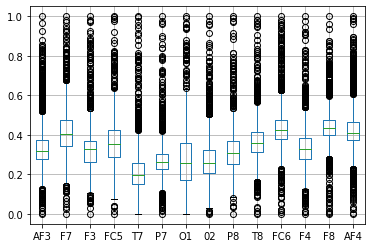

In [54]:
#Scaling trainfeatures and testfeatures
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)
test_features = scaler.transform(test_features)

#visualizing the trainfeatures' ranges
features = pd.DataFrame(features, columns=feature_names)
test_features = pd.DataFrame(test_features, columns=test_feature_names)
features.boxplot()

Okay, so I managed this. Now I have to choose a good model to fit the traindata and eventually to perform good on the test set too. I'll try once again with a **Logistic regression model** to have some actual predictions that don't only assign the testdata points to class 1.

In [55]:
model = LogisticRegression(C=1)
score_train = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score_train))

AUC score for trainset: 0.635987937648488


This AUC score 0.636 is not a very good score.

I will now try to find a **better hyperparameter C** for this model via GridsearchCV.

In [56]:
from sklearn.model_selection import GridSearchCV

search_space = [0.001,0.01,0.1,1,10,100,1000]

model = LogisticRegression(max_iter=200)
params = dict(C=search_space)
grid_search = GridSearchCV(model, param_grid=params)
grid_search.fit(features, trainset.label)

print(grid_search.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


These results suggest a model with **C=100**, we can now evaluate it's CV performance again like we did before. 

In [57]:
model = LogisticRegression(C=100,max_iter=200)
score_train = cross_val_score(model, features, trainset.label,scoring='roc_auc', cv= 10).mean()
print('AUC score for trainset: '+ str(score_train))

AUC score for trainset: 0.6593887855264002


I will now fit this better model to the trainset and look at the 14 different modelparameters. From this I can also calculate which feature seems to be more important to this model to deside which class a data point belongs to.

In [58]:
model.fit(features, trainset.label)
print(model.coef_[0])

[ 0.81315004 -3.85054242  1.99589737 -2.29567885  4.78511321 -7.32428061
  0.26431594 -0.326364    0.97461955  0.76238454 -2.22259149  2.17920036
  0.15890058  2.40164082]


In [64]:
importances_coef = []
for feature_name, modelparameter in zip(features.columns,model.coef_[0]):
    importances_coef.append([feature_name,modelparameter])
importances_coef = pd.DataFrame(importances_coef,columns=["feature_name","importance"])
importances_coef.sort_values(by='importance',ignore_index=True).head()  

,feature_name,importance
0,P7,-7.324281
1,F7,-3.850542
2,FC5,-2.295679
3,FC6,-2.222591
4,02,-0.326364


I can visualize these importances with a **barplot**:

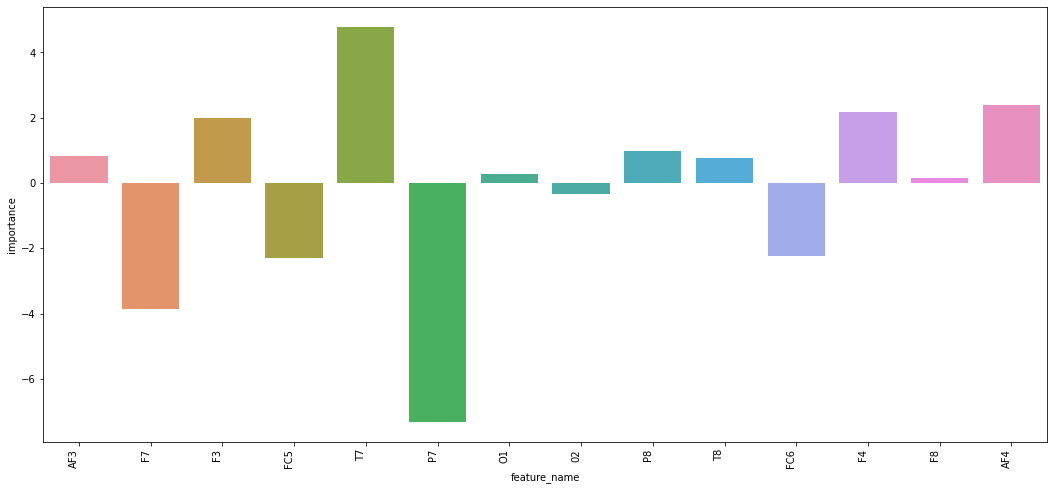

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,8))

importances = sns.barplot(x=importances_coef.feature_name, y=importances_coef.importance)

importances.set_xticklabels(importances.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

From this dataframe and barplot you can see that there are several features that are more important then others,
e.g. P7 seems to be an important feature for the class 0 (eyes open) and
T7 seems to be an important feature indicating a datapoint belongs to class 1 (closed eyes).